## **IMPORTING LIBRARIES AND LOADING DATA**


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import keras
import pandas as pd
import collections
from keras.utils.np_utils import to_categorical
import tensorflow_addons

image_data =np.load("trainvalid_images.npy")
labels=pd.read_csv('trainvalid_labels.csv')

# **DATA EXPLORATION**




In [2]:
#checking number of instances for each class in full data
labels['Label'].value_counts()

0    10506
1     2372
2      382
Name: Label, dtype: int64

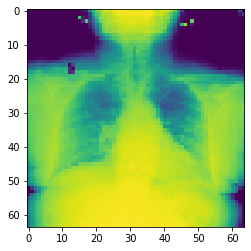

In [3]:
#image of how an X-ray looks like in dataset
plt.imshow(image_data[0].reshape(64,64))

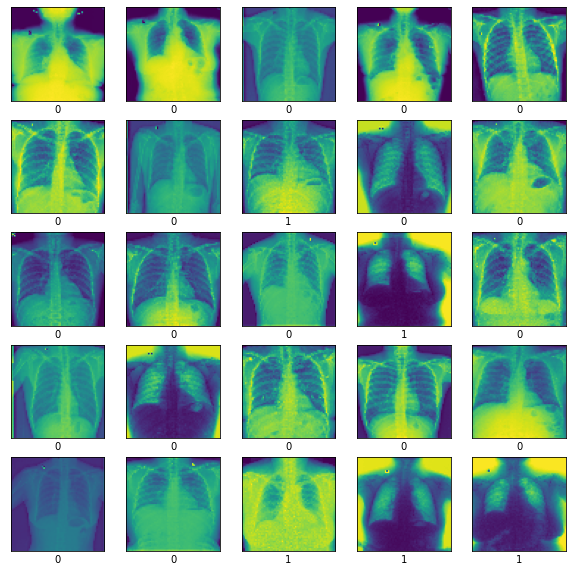

In [4]:
# plotting first 25 images of the train set with their classification
class_names=['0','1','2']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_data[i].reshape(64,64))
    plt.xlabel(class_names[labels['Label'].iloc[i]])
plt.show()

In [5]:
#checking dimension and data type of image data
image_data.shape,image_data.dtype

((13260, 64, 64, 1), dtype('uint8'))

# **OVERSAMPLING DATA AND TRAIN-TEST SPLIT**

In [6]:
#changing labels to one hot vectors
categorical_labels = to_categorical(labels['Label'], num_classes=3)

In [7]:
#Oversampling the data to create balanced dataset
class1 = []
class2 = []
for i in range(len(labels)):
    if categorical_labels[i][1]==1:
        class1.append(i)
    if categorical_labels[i][2]==1:
        class2.append(i)

number_of_copies1=2
number_of_copies2=20

for i in range(number_of_copies1):
    image_data = np.concatenate((image_data, image_data[class1].copy()),axis=0)
    categorical_labels = np.concatenate((categorical_labels, categorical_labels[class1].copy()),axis=0)

for i in range(number_of_copies2):
    image_data = np.concatenate((image_data, image_data[class2].copy()),axis=0)
    categorical_labels = np.concatenate((categorical_labels, categorical_labels[class2].copy()),axis=0) 

shuffler = np.random.permutation(len(image_data))
image_over = image_data[shuffler]
label_over = categorical_labels[shuffler]

In [8]:
#splitting data into 80% and 20% for train and test set respectively
train_x,test_x,train_y, test_y=sklearn.model_selection.train_test_split(image_over,label_over,train_size=0.8,random_state=0)

In [9]:
#checking number of instances for each class in training data
class_labels = np.argmax(train_y, axis=1)
collections.Counter(class_labels)

Counter({0: 8436, 1: 5684, 2: 6395})

# **DATA PREPROCESSING**

In [10]:
#reshaping train and test data images and changing data type to float
train_x=train_x.reshape(-1,64,64,1)/255.0
test_x=test_x.reshape(-1,64,64,1)/255.0

# **DATA AUGMENTATION**

In [11]:
#defining a data augmentation pipeline for dealing with imbalanced data
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(64,64,1)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
   tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2,seed=0),
  ]
)

## **TESTING DIFFERENT ARCHITECTURES**

**LeNet-5 model 1**

In [12]:
#Training LeNet-5 model 1 with metrtics accuracy, AUC, macro F1 score, micro F1 score
lenet5_1=tf.keras.Sequential([data_augmentation,tf.keras.layers.Conv2D(filters=20,kernel_size=(5,5),activation='relu',input_shape=(64,64,1)),
                              tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='same'),
                          tf.keras.layers.Conv2D(filters=50,kernel_size=(5,5),activation='relu'),
                              tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='same'),
                            tf.keras.layers.Conv2D(filters=70,kernel_size=(5,5),activation='relu'),
                              tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='same'),
                        
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(500,activation='relu'),
                          
                          tf.keras.layers.Dense(600,activation='relu'),
                          tf.keras.layers.Dropout(0.4),
                          tf.keras.layers.Dense(700,activation='relu'),
                          tf.keras.layers.Dense(3,activation='softmax')])
lenet5_1.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
               metrics=['accuracy','AUC',tensorflow_addons.metrics.F1Score(num_classes=3,average='macro',name='F1_macro'),
              tensorflow_addons.metrics.F1Score(num_classes=3,average='micro',name='F1_micro')])
lenet5_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 50)        25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 70)          87570     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 70)         

In [13]:
#Fitting the model on train data
lenet5_1.fit(train_x,train_y,epochs=20,validation_split=0.2)

Epoch 1/20
513/513 [==============================] - 9s 11ms/step - loss: 1.0380 - accuracy: 0.4490 - auc: 0.6409 - F1_macro: 0.3686 - F1_micro: 0.4490 - val_loss: 0.9412 - val_accuracy: 0.5108 - val_auc: 0.7351 - val_F1_macro: 0.3757 - val_F1_micro: 0.5108
Epoch 2/20
513/513 [==============================] - 5s 9ms/step - loss: 0.8943 - accuracy: 0.5543 - auc: 0.7627 - F1_macro: 0.5147 - F1_micro: 0.5543 - val_loss: 0.8008 - val_accuracy: 0.5976 - val_auc: 0.8121 - val_F1_macro: 0.5652 - val_F1_micro: 0.5976
Epoch 3/20
513/513 [==============================] - 5s 9ms/step - loss: 0.8143 - accuracy: 0.6059 - auc: 0.8079 - F1_macro: 0.5742 - F1_micro: 0.6059 - val_loss: 0.7656 - val_accuracy: 0.6232 - val_auc: 0.8306 - val_F1_macro: 0.5755 - val_F1_micro: 0.6232
Epoch 4/20
513/513 [==============================] - 5s 9ms/step - loss: 0.7550 - accuracy: 0.6436 - auc: 0.8378 - F1_macro: 0.6121 - F1_micro: 0.6436 - val_loss: 0.7156 - val_accuracy: 0.6746 - val_auc: 0.8554 - val_F1_macr

In [14]:
#Evaluating the model
lenet5_1.evaluate(test_x,test_y)

161/161 [==============================] - 1s 5ms/step - loss: 0.4641 - accuracy: 0.7953 - auc: 0.9423 - F1_macro: 0.7787 - F1_micro: 0.7953


[0.46410319209098816,
 0.795281708240509,
 0.9422599673271179,
 0.7786588668823242,
 0.795281708240509]

**LeNet-5 model 2**

In [15]:
#Training LeNet-5 model with metrtics accuracy, AUC, macro F1 score, micro F1 score
lenet5_2=tf.keras.Sequential([data_augmentation,tf.keras.layers.Conv2D(filters=20,kernel_size=(5,5),activation='relu',input_shape=(64,64,1)),
                              tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='valid'),
                          tf.keras.layers.Conv2D(filters=50,kernel_size=(5,5),activation='relu'),
                              tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='valid'),
                            tf.keras.layers.Conv2D(filters=70,kernel_size=(5,5),activation='relu'),
                              tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='valid'),
                        
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(500,activation='relu'),
                          tf.keras.layers.Dense(600,activation='relu'),
                          tf.keras.layers.Dropout(0.4),
                        
                          tf.keras.layers.Dense(3,activation='softmax')])
lenet5_2.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
               metrics=['accuracy','AUC',tensorflow_addons.metrics.F1Score(num_classes=3,average='macro',name='F1_macro'),
              tensorflow_addons.metrics.F1Score(num_classes=3,average='micro',name='F1_micro')])
lenet5_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 50)        25050     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 70)          87570     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 70)         

In [16]:
#Fitting the model on train data
lenet5_2.fit(train_x,train_y,epochs=23,validation_split=0.2)

Epoch 1/23
513/513 [==============================] - 6s 10ms/step - loss: 1.0162 - accuracy: 0.4800 - auc: 0.6660 - F1_macro: 0.4002 - F1_micro: 0.4800 - val_loss: 0.8582 - val_accuracy: 0.5455 - val_auc: 0.7785 - val_F1_macro: 0.4564 - val_F1_micro: 0.5455
Epoch 2/23
513/513 [==============================] - 5s 9ms/step - loss: 0.8712 - accuracy: 0.5640 - auc: 0.7757 - F1_macro: 0.5218 - F1_micro: 0.5640 - val_loss: 0.7810 - val_accuracy: 0.6366 - val_auc: 0.8222 - val_F1_macro: 0.6048 - val_F1_micro: 0.6366
Epoch 3/23
513/513 [==============================] - 5s 9ms/step - loss: 0.8027 - accuracy: 0.6187 - auc: 0.8139 - F1_macro: 0.5888 - F1_micro: 0.6187 - val_loss: 0.7457 - val_accuracy: 0.6498 - val_auc: 0.8462 - val_F1_macro: 0.6278 - val_F1_micro: 0.6498
Epoch 4/23
513/513 [==============================] - 5s 9ms/step - loss: 0.7477 - accuracy: 0.6502 - auc: 0.8423 - F1_macro: 0.6247 - F1_micro: 0.6502 - val_loss: 0.6994 - val_accuracy: 0.6812 - val_auc: 0.8627 - val_F1_macr

In [17]:
#Evaluating the model
lenet5_2.evaluate(test_x,test_y)

161/161 [==============================] - 1s 5ms/step - loss: 0.3831 - accuracy: 0.8460 - auc: 0.9599 - F1_macro: 0.8360 - F1_micro: 0.8460


[0.3830812871456146,
 0.8459738492965698,
 0.9599201083183289,
 0.835963249206543,
 0.8459738492965698]

**VGG model 1**

In [18]:
#Training a VGG model with metrtics acccuracy, AUC, macro F1 score and micro F1 score
vgg_1=tf.keras.Sequential([data_augmentation,tf.keras.layers.Conv2D(32,(5,5),padding='same', activation='relu',input_shape=(64,64,1)),
                         tf.keras.layers.Conv2D(32,(5,5),padding='same', activation='relu'),
                         tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                         
                         tf.keras.layers.Conv2D(64,(5,5),padding='same', activation='relu'),
                         tf.keras.layers.Conv2D(64,(5,5),padding='same', activation='relu'),
                         tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                         
                         
                         
                         tf.keras.layers.Flatten(),
                         tf.keras.layers.Dense(512,activation='relu'),
                        #tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Dense(600,activation='relu'),
                        # tf.keras.layers.Dense(700,activation='relu'),
                         #tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Dense(3,activation='softmax')])

vgg_1.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
            metrics=['accuracy','AUC',tensorflow_addons.metrics.F1Score(num_classes=3,average='macro',name='F1_macro'),
              tensorflow_addons.metrics.F1Score(num_classes=3,average='micro',name='F1_micro')])
vgg_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)       

In [19]:
#Fitting the model on train data
vgg_1.fit(train_x,train_y,epochs=20,validation_split=0.2)

Epoch 1/20
513/513 [==============================] - 13s 22ms/step - loss: 1.0523 - accuracy: 0.4447 - auc: 0.6306 - F1_macro: 0.3411 - F1_micro: 0.4447 - val_loss: 0.8965 - val_accuracy: 0.5728 - val_auc: 0.7724 - val_F1_macro: 0.5488 - val_F1_micro: 0.5728
Epoch 2/20
513/513 [==============================] - 10s 20ms/step - loss: 0.8969 - accuracy: 0.5742 - auc: 0.7678 - F1_macro: 0.5275 - F1_micro: 0.5742 - val_loss: 0.7883 - val_accuracy: 0.6395 - val_auc: 0.8253 - val_F1_macro: 0.5976 - val_F1_micro: 0.6395
Epoch 3/20
513/513 [==============================] - 10s 20ms/step - loss: 0.7856 - accuracy: 0.6382 - auc: 0.8266 - F1_macro: 0.6050 - F1_micro: 0.6382 - val_loss: 0.7146 - val_accuracy: 0.6717 - val_auc: 0.8585 - val_F1_macro: 0.6546 - val_F1_micro: 0.6717
Epoch 4/20
513/513 [==============================] - 10s 20ms/step - loss: 0.7472 - accuracy: 0.6580 - auc: 0.8442 - F1_macro: 0.6315 - F1_micro: 0.6580 - val_loss: 0.7376 - val_accuracy: 0.6505 - val_auc: 0.8446 - val_

In [20]:
#evaluating model with test data
vgg_1.evaluate(test_x,test_y,verbose=2)

161/161 - 1s - loss: 0.4149 - accuracy: 0.8333 - auc: 0.9530 - F1_macro: 0.8229 - F1_micro: 0.8333


[0.414883553981781,
 0.8333008289337158,
 0.9529727697372437,
 0.8229401707649231,
 0.8333008885383606]

**VGG model 2**

In [21]:
#Training a VGG model with metrtics acccuracy, AUC, macro F1 score and micro F1 score
vgg_2=tf.keras.Sequential([data_augmentation,tf.keras.layers.Conv2D(64,(5,5),padding='same', activation='relu',input_shape=(64,64,1)),
                         tf.keras.layers.Conv2D(64,(5,5),padding='same', activation='relu'),
                         tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                         
                         tf.keras.layers.Conv2D(128,(5,5),padding='same', activation='relu'),
                         tf.keras.layers.Conv2D(128,(5,5),padding='same', activation='relu'),
                         tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                         
                         
                         
                         tf.keras.layers.Flatten(),
                         tf.keras.layers.Dense(512,activation='relu'),
                        #tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Dense(600,activation='relu'),
                        tf.keras.layers.Dense(700,activation='relu'),
                         #tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Dense(3,activation='softmax')])

vgg_2.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
            metrics=['accuracy','AUC',tensorflow_addons.metrics.F1Score(num_classes=3,average='macro',name='F1_macro'),
              tensorflow_addons.metrics.F1Score(num_classes=3,average='micro',name='F1_micro')])
vgg_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        1664      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 128)       409728    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 128)      

In [22]:
#Fitting the model on train data
vgg_2.fit(train_x,train_y,epochs=20,validation_split=0.2)

Epoch 1/20
513/513 [==============================] - 22s 39ms/step - loss: 1.0276 - accuracy: 0.4690 - auc: 0.6594 - F1_macro: 0.3895 - F1_micro: 0.4690 - val_loss: 0.9249 - val_accuracy: 0.5589 - val_auc: 0.7546 - val_F1_macro: 0.5198 - val_F1_micro: 0.5589
Epoch 2/20
513/513 [==============================] - 18s 36ms/step - loss: 0.8911 - accuracy: 0.5664 - auc: 0.7666 - F1_macro: 0.5138 - F1_micro: 0.5664 - val_loss: 0.8044 - val_accuracy: 0.6044 - val_auc: 0.8140 - val_F1_macro: 0.5583 - val_F1_micro: 0.6044
Epoch 3/20
513/513 [==============================] - 18s 36ms/step - loss: 0.8131 - accuracy: 0.6081 - auc: 0.8098 - F1_macro: 0.5735 - F1_micro: 0.6081 - val_loss: 0.7595 - val_accuracy: 0.6459 - val_auc: 0.8407 - val_F1_macro: 0.5861 - val_F1_micro: 0.6459
Epoch 4/20
513/513 [==============================] - 18s 36ms/step - loss: 0.7806 - accuracy: 0.6303 - auc: 0.8275 - F1_macro: 0.5964 - F1_micro: 0.6303 - val_loss: 0.7171 - val_accuracy: 0.6734 - val_auc: 0.8587 - val_

In [23]:
#evaluating model with test data
vgg_2.evaluate(test_x,test_y,verbose=2)

161/161 - 2s - loss: 0.4501 - accuracy: 0.8023 - auc: 0.9432 - F1_macro: 0.7902 - F1_micro: 0.8023


[0.45012596249580383,
 0.8023006319999695,
 0.9431924223899841,
 0.7901747822761536,
 0.8023006319999695]

**VGG model 3**

In [24]:
#Training a VGG model with metrtics acccuracy, AUC, macro F1 score and micro F1 score
vgg_3=tf.keras.Sequential([data_augmentation,
                        tf.keras.layers.Conv2D(64,(5,5),padding='same', activation='relu',input_shape=(64,64,1)),
                        tf.keras.layers.Conv2D(64,(5,5),padding='same', activation='relu'),
                        tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                         
                        tf.keras.layers.Conv2D(128,(5,5),padding='same', activation='relu'),
                        tf.keras.layers.Conv2D(128,(5,5),padding='same', activation='relu'),
                        tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'), 
                                              
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(512,activation='relu'),
                        tf.keras.layers.Dense(600,activation='relu'),
                        tf.keras.layers.Dense(700,activation='relu'),
                        tf.keras.layers.Dense(3,activation='softmax')])

vgg_3.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
            metrics=['accuracy','AUC',tensorflow_addons.metrics.F1Score(num_classes=3,average='macro',name='F1_macro'),
                                      tensorflow_addons.metrics.F1Score(num_classes=3,average='micro',name='F1_micro')])
vgg_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        1664      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       409728    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 128)      

In [25]:
#Fitting the model on train data
vgg_3.fit(train_x,train_y,epochs=50,validation_split=0.2)

Epoch 1/50
513/513 [==============================] - 20s 37ms/step - loss: 1.1128 - accuracy: 0.4080 - auc: 0.5663 - F1_macro: 0.2081 - F1_micro: 0.4080 - val_loss: 1.0863 - val_accuracy: 0.4041 - val_auc: 0.5635 - val_F1_macro: 0.1919 - val_F1_micro: 0.4041
Epoch 2/50
513/513 [==============================] - 18s 36ms/step - loss: 1.0850 - accuracy: 0.4111 - auc: 0.5653 - F1_macro: 0.1942 - F1_micro: 0.4111 - val_loss: 1.0867 - val_accuracy: 0.4041 - val_auc: 0.5635 - val_F1_macro: 0.1919 - val_F1_micro: 0.4041
Epoch 3/50
513/513 [==============================] - 18s 36ms/step - loss: 1.0840 - accuracy: 0.4133 - auc: 0.5715 - F1_macro: 0.1949 - F1_micro: 0.4133 - val_loss: 1.0865 - val_accuracy: 0.4041 - val_auc: 0.5635 - val_F1_macro: 0.1919 - val_F1_micro: 0.4041
Epoch 4/50
513/513 [==============================] - 18s 36ms/step - loss: 1.0856 - accuracy: 0.4095 - auc: 0.5626 - F1_macro: 0.1937 - F1_micro: 0.4095 - val_loss: 1.0869 - val_accuracy: 0.4041 - val_auc: 0.5635 - val_

In [26]:
#evaluating model with test data
vgg_3.evaluate(test_x,test_y,verbose=2)

161/161 - 2s - loss: 1.0868 - accuracy: 0.4036 - auc: 0.5622 - F1_macro: 0.1917 - F1_micro: 0.4036


[1.0868051052093506,
 0.4035874307155609,
 0.562195360660553,
 0.1916932910680771,
 0.4035874307155609]

# **Comparing models**

In [29]:
# Model table
m=['LeNet-5 model 1','LeNet-5 model 2','VGG model 1','VGG model 2','VGG model 3']
loss=[0.4641,0.3831,0.4149,0.4501,1.0868]
accuracy=[0.7953,0.8460,0.8333,0.8023,0.4036]
auc=[0.9423,0.9599,0.9530,0.9432,0.5622]
F1_macro=[ 0.7787,0.8360,0.8229,0.7902, 0.1917 ]
F1_micro=[0.7953,0.8460,0.8333,0.8023,0.4036]
df=pd.DataFrame([loss,accuracy,auc,F1_macro,F1_micro],index=['Loss','Accuracy','AUC  score','F1_macro score','F1_micro score'],columns=[m])

In [30]:
df

,LeNet-5 model 1,LeNet-5 model 2,VGG model 1,VGG model 2,VGG model 3
Loss,0.4641,0.3831,0.4149,0.4501,1.0868
Accuracy,0.7953,0.8460,0.8333,0.8023,0.4036
AUC score,0.9423,0.9599,0.9530,0.9432,0.5622
F1_macro score,0.7787,0.8360,0.8229,0.7902,0.1917
F1_micro score,0.7953,0.8460,0.8333,0.8023,0.4036


**I therefore chose VGG model 1 as my final model, trained on 20 epochs**